## Week 12 Homework (10)

### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

**Gaussian Processes (GPs) and Stochastic Processes:**
A GP is a collection of random variables, any finite number of which have a joint Gaussian distribution. It defines a distribution over functions, meaning that instead of having a fixed function form, a GP specifies a mean function and a covariance function (kernel) that together determine the similarity between function values at different input locations. In a broader sense, a stochastic process is any collection of random variables indexed by a set (often time or space), describing how a system evolves randomly over time or space. While GPs are a specific type of stochastic process with Gaussian marginal distributions, stochastic processes can also include non-Gaussian processes, Markov chains, Poisson processes, and more.

**Variational Inference using the Evidence Lower Bound (ELBO):**
VI is an approach to approximate intractable posterior distributions by positing a simpler, parameterized distribution and then optimizing its parameters to be as close as possible to the true posterior. This closeness is measured using KL divergence. The optimization objective is the Evidence Lower Bound (ELBO), which serves as a lower bound on the log marginal likelihood. Maximizing the ELBO minimizes the divergence between the variational approximation and the true posterior which then yields a tractable approximation for Bayesian inference.

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


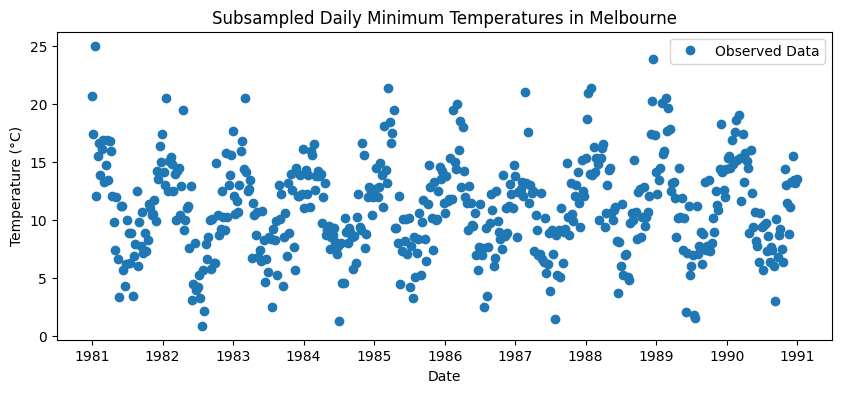

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load the Daily Minimum Temperatures dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'])
print(data.head())

# Subsample the data to reduce computational cost (take one observation per week)
subsample_factor = 7
data_sub = data.iloc[::subsample_factor, :].reset_index(drop=True)

# Extract the dates and temperature values from the subsampled data
dates = data_sub['Date']
temperatures = data_sub['Temp'].values
days = (dates - dates.min()).dt.days.values.astype(float)

plt.figure(figsize=(10, 4))
plt.plot(dates, temperatures, 'o', label='Observed Data')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Subsampled Daily Minimum Temperatures in Melbourne")
plt.legend()
plt.show()

In [2]:
# Fit a Gaussian Process using PyMC on the subsampled data
with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Constant(c=np.mean(temperatures))

    cov_func = pm.gp.cov.ExpQuad(1, ls=50)

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    f = gp.prior("f", X=days[:, None])

    sigma = pm.Exponential("sigma", 1.0)
    y = pm.Normal("y", mu=f, sigma=sigma, observed=temperatures)

    trace_gp = pm.sample(1000, tune=1000, chains=4, target_accept=0.95, return_inferencedata=True)

# Posterior predictive sampling
with gp_model:
    pred_samples = pm.sample_posterior_predictive(trace_gp, var_names=["f"], random_seed=42)

f_samples = pred_samples.posterior_predictive["f"].values  # shape: (chain, draw, f_dim_0)
f_samples = f_samples.reshape(-1, f_samples.shape[-1])  # shape: (total_samples, n)



Output()

Output()

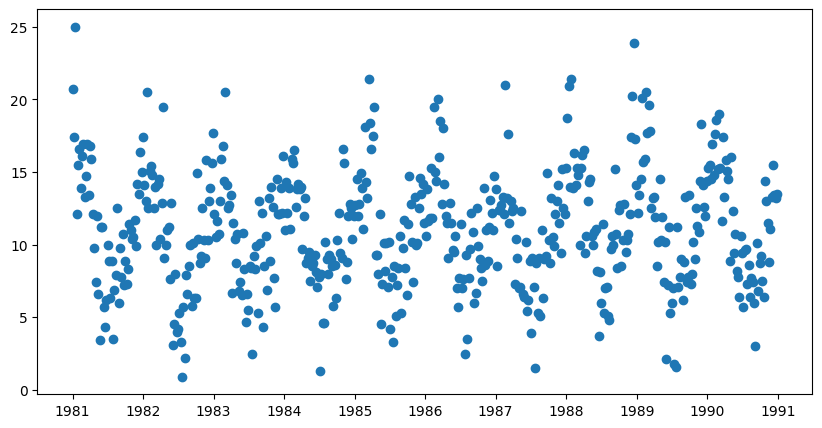

In [3]:
# Plot the GP fit to the subsampled data
plt.figure(figsize=(10, 5))
plt.plot(dates, temperatures, 'o', label="Observed Data")


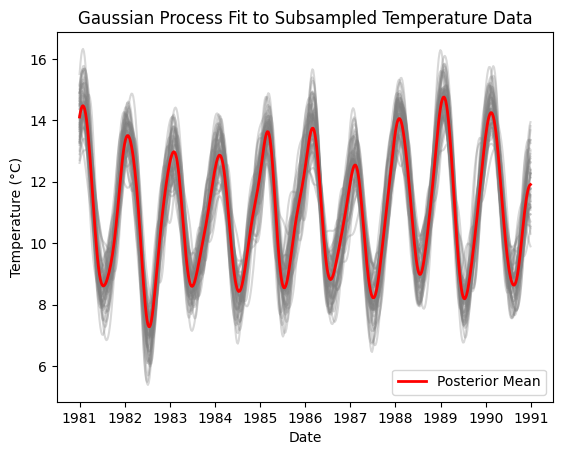

In [4]:
for i in range(50):
    plt.plot(dates, f_samples[i], color="gray", alpha=0.3)
plt.plot(dates, np.mean(f_samples, axis=0), color="red", lw=2, label="Posterior Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Gaussian Process Fit to Subsampled Temperature Data")
plt.legend()
plt.show()

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



In [5]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# Load and prepare the California Housing dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Standardize predictors and response
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

n, p = X_scaled.shape

# Define a simple feed-forward neural network with one hidden layer using variational inference
with pm.Model() as nn_model:
    n_hidden = 10
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(p, n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    hidden = pm.math.tanh(pm.math.dot(X_scaled, w1) + b1)
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(n_hidden, 1))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    mu_nn = pm.math.dot(hidden, w2) + b2
    sigma_nn = pm.Exponential("sigma_nn", 1.0)
    y_obs = pm.Normal("y_obs", mu=mu_nn.flatten(), sigma=sigma_nn, observed=y_scaled)
    approx = pm.fit(n=10000, method='advi')
    trace_nn = approx.sample(draws=5000)

Output()

In [6]:
az.summary(trace_nn, var_names=["w1", "w2", "b1", "b2", "sigma_nn"])

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w1[0, 0]",-0.168,0.627,-1.376,0.990,0.009,0.006,4879.0,4645.0,NaN
"w1[0, 1]",-0.228,0.625,-1.396,0.927,0.009,0.006,4895.0,5121.0,NaN
"w1[0, 2]",-0.094,0.625,-1.235,1.113,0.009,0.006,4969.0,4821.0,NaN
"w1[0, 3]",-0.083,0.603,-1.243,0.992,0.008,0.006,5040.0,4793.0,NaN
"w1[0, 4]",0.132,0.638,-1.013,1.362,0.009,0.007,4801.0,4538.0,NaN
...,...,...,...,...,...,...,...,...,...
b1[7],-0.004,0.627,-1.197,1.133,0.009,0.006,4686.0,4858.0,NaN
b1[8],-0.023,0.601,-1.151,1.108,0.008,0.007,5053.0,4049.0,NaN
b1[9],-0.001,0.607,-1.140,1.126,0.009,0.006,4704.0,4716.0,NaN
b2,-0.001,0.199,-0.356,0.389,0.003,0.002,4399.0,5064.0,NaN


The ADVI-based neural network model produces approximate posterior summaries for the network parameters (weights, biases, and noise scale) based on 5000 draws from a single chain. The summary output provides means, standard deviations, and 94% highest density intervals (HDI) for each parameter, indicating the uncertainty in their estimates. However, since only one chain was generated, convergence diagnostics like \(\hat{r}\) and effective sample sizes cannot be reliably computed. Despite this limitation, the reported values suggest that the model has learned stable parameter estimates, with many parameters exhibiting relatively tight credible intervals. Overall, while the ADVI approach appears to yield reasonable estimates for the neural network, obtaining multiple chains in future analyses would strengthen convergence assessment and improve the robustness of the inference.

Output()

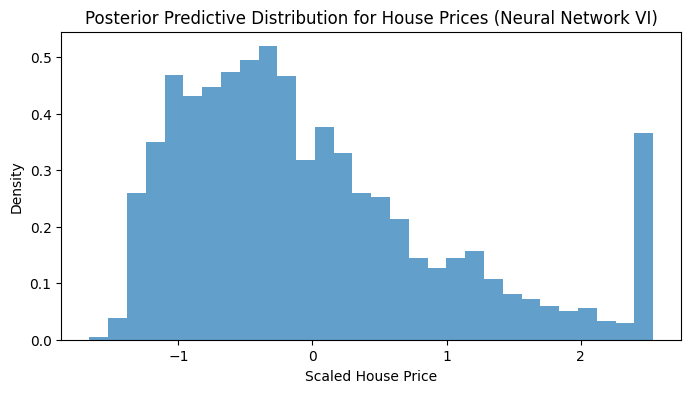

In [7]:
with nn_model:
    ppc = pm.sample_posterior_predictive(trace_nn, var_names=["y_obs"], random_seed=42)

plt.figure(figsize=(8, 4))
plt.hist(ppc.observed_data["y_obs"].values.flatten(), bins=30, density=True, alpha=0.7)
plt.xlabel("Scaled House Price")
plt.ylabel("Density")
plt.title("Posterior Predictive Distribution for House Prices (Neural Network VI)")
plt.show()

This histogram shows the posterior predictive distribution of scaled house prices obtained from the ADVI‐fitted neural network. Each bar represents how frequently the model predicts a particular scaled price range, based on posterior draws of the network’s weights and biases. The distribution is centered around values near zero to two, indicating the model’s predictions for most homes in the dataset fall in this range after scaling. The spike at the far right (near 2) suggests the model occasionally predicts higher‐end prices for some portion of the data. Overall, this distribution provides a sense of the model’s uncertainty and coverage in its house price predictions, although its shape is influenced by both the model’s architecture and the variational approximation method.